# Evaluation model

在此我們的架構選用跟助教舊的版本(4類)，每個class隨機挑20000筆資料，總共湊成80000 training data，並做了up down flip的data augumentation，之後隨機挑example湊成一個batch，丟進CNN做training。Training 部分我們有用validation loss 來看是否有無overfitting，當loss和accuracy都開始震盪時，我們就停止training了。

In [136]:
# import the required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=8,suppress=True)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [137]:
# function used to draw a sketch
def get_bounds(data, factor=10):
  """Return bounds of data."""
  min_x = 0
  max_x = 0
  min_y = 0
  max_y = 0

  abs_x = 0
  abs_y = 0
  for i in range(len(data)):
    x = float(data[i, 0]) / factor
    y = float(data[i, 1]) / factor
    abs_x += x
    abs_y += y
    min_x = min(min_x, abs_x)
    min_y = min(min_y, abs_y)
    max_x = max(max_x, abs_x)
    max_y = max(max_y, abs_y)
  return (min_x, max_x, min_y, max_y)


def draw_strokes(data,
                 svg_filename='/tmp/sketch_rnn/svg/sample.svg',
                 factor=0.2,
                 show_pen_sequence=False,
                 who_draw_the_stroke=None):
  if not os.path.exists(os.path.dirname(svg_filename)):
    os.makedirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "M"
  xs = []
  ys = []
  for i in range(len(data)):
    if (lift_pen == 1):
      command = "M"
    elif (command != "L"):
      command = "L"
    else:
      command = ""
    x = float(data[i, 0]) / factor
    y = float(data[i, 1]) / factor
    abs_x += x
    abs_y += y
    xs.append(abs_x)
    ys.append(abs_y)
    lift_pen = data[i, 2]
    p += command + str(abs_x) + "," + str(abs_y) + " "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))
  color = 'black'
  if show_pen_sequence:
    turn = 0
    for i in range(1, len(xs)):
      dwg.add(
          dwg.text(
              '{}'.format(i),
              insert=(xs[i], ys[i]),
              font_size="10px",
              fill=color))
      if who_draw_the_stroke is not None:
        if data[i, 2] == 1:
          color = 'red' if who_draw_the_stroke[turn] == 0 else 'black'
          turn += 1
  display(SVG(dwg.tostring()))

In [138]:
# load data
data = np.load('./dataset/microphone.full.npz', encoding='latin1')
train_sketches = data['train']
valid_sketches = data['valid']
test_sketches = data['test']
print('num train: {}'.format(len(train_sketches)))
print('num valid: {}'.format(len(valid_sketches)))
print('num test: {}'.format(len(test_sketches)))

num train: 103938
num valid: 2500
num test: 2500


[[  -4   -6    0]
 [ -15   -1    0]
 [ -28   13    0]
 [ -10   18    0]
 [  -2   15    0]
 [  13   20    0]
 [  22    4    0]
 [   7   -2    0]
 [  12   -8    0]
 [   6   -9    0]
 [   0  -31    0]
 [  -6  -16    0]
 [  -7   -4    1]
 [ -38   13    0]
 [   5   37    0]
 [   6   18    1]
 [   1  -62    0]
 [  10   67    1]
 [   1  -73    0]
 [  13   67    0]
 [   5    8    1]
 [  -8  -68    0]
 [  12   47    1]
 [ -50  -20    0]
 [  24  -11    0]
 [  22   -6    1]
 [ -51   36    0]
 [  33  -14    0]
 [  21   -5    1]
 [ -39   25    0]
 [  27   -3    0]
 [  11   -8    1]
 [ -37   32    0]
 [   0   33    0]
 [   5    2    0]
 [  38   -7    0]
 [ -13  -32    1]
 [ -16    7    0]
 [   4   11    1]
 [-188  -38    0]
 [   0   20    0]
 [  -5   26    0]
 [   6    2    0]
 [  86   -7    0]
 [  38    1    0]
 [   2   -5    0]
 [  -8  -47    0]
 [ -18    6    0]
 [ -47    6    0]
 [ -51    3    0]
 [ -18   -1    1]
 [  57    0    0]
 [  -7   -9    0]
 [  -1   -8    0]
 [  12  -18    0]
 [   9   -

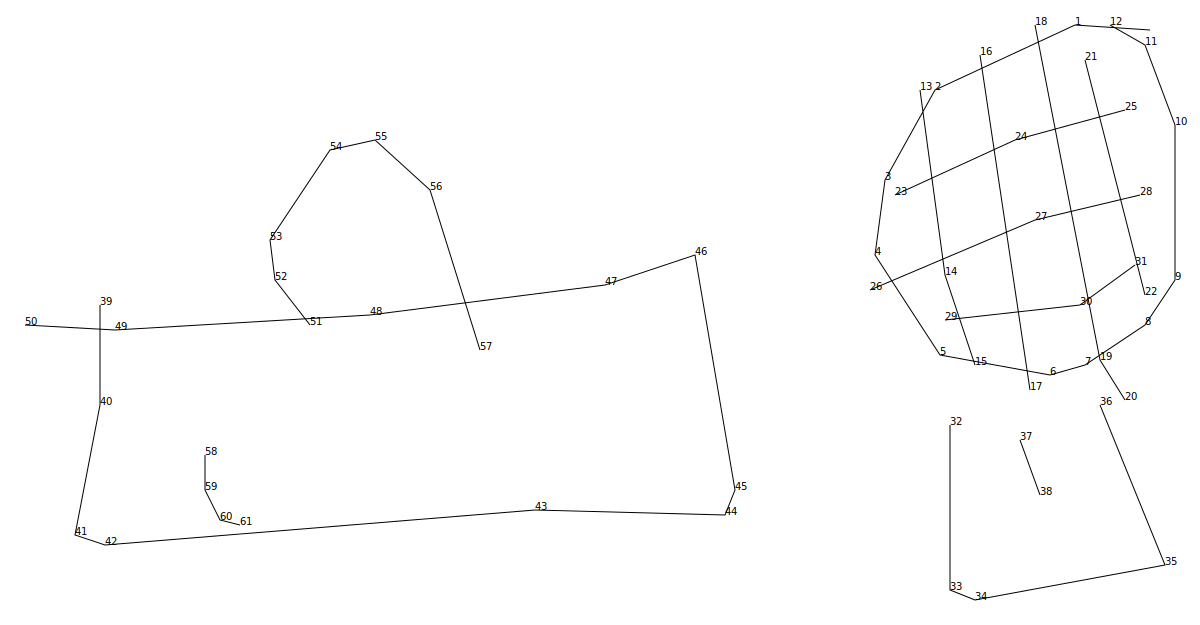

In [139]:
# see data format and draw it
print(train_sketches[0])
draw_strokes(train_sketches[0], show_pen_sequence=True)

In [140]:
def preprocess(sketches, limit=1000):
  raw_data = []
  seq_len = []
  count_data = 0

  for i in range(len(sketches)):
    data = sketches[i]
    count_data += 1
    # removes large gaps from the data
    data = np.minimum(data, limit)
    data = np.maximum(data, -limit)
    data = np.array(data, dtype=np.float32)
    raw_data.append(data)
    seq_len.append(len(data))
  seq_len = np.array(seq_len)  # nstrokes for each sketch
  idx = np.argsort(seq_len)
  sketches = []
  for i in range(len(seq_len)):
    sketches.append(raw_data[idx[i]])
  return raw_data


def normalize(sketches):
  """Normalize entire dataset (delta_x, delta_y) to [-1,1]."""
  result = []
  for i in range(len(sketches)):
    tmp = sketches[i]
    sketches[i][:, :2] /= np.max(np.abs(sketches[i][:, :2]))
    result.append(tmp)
  return result


def to_big_strokes(strokes):
  """Converts from stroke-3 to stroke-5 format and pads to given length, but does not insert special start token)."""

  result = np.zeros((len(strokes), 5), dtype=float)
  l = len(strokes)
  result[0:l, 0:2] = strokes[:, 0:2]
  result[0:l, 3] = strokes[:, 2]
  result[0:l, 2] = 1 - result[0:l, 3]
  result[l:, 4] = 1
  return result


def to_big_sketches(sketches):
  result = []
  for i in range(len(sketches)):
    sketch = to_big_strokes(sketches[i])
    result.append(sketch)
  return result


def to_normal_strokes(big_strokes):
  """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
  l = 0
  for i in range(len(big_strokes)):
    if big_strokes[i, 4] > 0:
      l = i
      break
  if l == 0:
    l = len(big_strokes)
  result = np.zeros((l, 3))
  result[:, 0:2] = big_strokes[0:l, 0:2]
  result[:, 2] = big_strokes[0:l, 3]
  return result

In [141]:
# preprocess sketches
train_sketches = preprocess(train_sketches)
valid_sketches = preprocess(valid_sketches)
test_sketches = preprocess(test_sketches)

train_sketches = normalize(train_sketches)
valid_sketches = normalize(valid_sketches)
test_sketches = normalize(test_sketches)

# convert to stroke-5 format
train_sketches = to_big_sketches(train_sketches)
valid_sketches = to_big_sketches(valid_sketches)
test_sketches = to_big_sketches(test_sketches)

[[-0.0212766  -0.03191489  0.        ]
 [-0.07978723 -0.00531915  0.        ]
 [-0.14893617  0.06914894  0.        ]
 [-0.05319149  0.09574468  0.        ]
 [-0.0106383   0.07978723  0.        ]
 [ 0.06914894  0.10638298  0.        ]
 [ 0.11702128  0.0212766   0.        ]
 [ 0.03723404 -0.0106383   0.        ]
 [ 0.06382979 -0.04255319  0.        ]
 [ 0.03191489 -0.04787234  0.        ]
 [ 0.         -0.16489361  0.        ]
 [-0.03191489 -0.08510638  0.        ]
 [-0.03723404 -0.0212766   1.        ]
 [-0.20212767  0.06914894  0.        ]
 [ 0.02659575  0.19680852  0.        ]
 [ 0.03191489  0.09574468  1.        ]
 [ 0.00531915 -0.32978722  0.        ]
 [ 0.05319149  0.35638297  1.        ]
 [ 0.00531915 -0.38829789  0.        ]
 [ 0.06914894  0.35638297  0.        ]
 [ 0.02659575  0.04255319  1.        ]
 [-0.04255319 -0.36170211  0.        ]
 [ 0.06382979  0.25        1.        ]
 [-0.26595744 -0.10638298  0.        ]
 [ 0.12765957 -0.05851064  0.        ]
 [ 0.11702128 -0.03191489

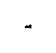

In [142]:
print(to_normal_strokes(train_sketches[0]))
draw_strokes(to_normal_strokes(train_sketches[0]))

In [143]:
def render_imgs(strokes, img_size, max_seq_len):
  """ 
    convert 5-strokes format to image
        args:
            sketches: shape(data_size, max_seq_len, 5)
    """

  xy = np.cumsum(strokes[:, :, 0:2], axis=1)  # (data_size, max_seq, 2)
  min_xy = np.min(xy, axis=(1), keepdims=True)  # (data_size, 1, 2)
  xy = xy - min_xy  # (data_size, max_seq, 2)
  max_xy = np.max(xy, axis=(1), keepdims=True)  # (data_size, 1, 2)
  max_xy = np.where(max_xy == 0, np.ones([len(strokes), 1, 2]),
                    max_xy)  # avoid divide by 0
  xy = xy / max_xy  # (data_size, max_seq, 2)
  xy = xy * (img_size - 1)  # (data_size, max_seq, 2)

  strokes_idx = np.tile(np.arange(len(strokes))[:, None],
                        [1, img_size])  # (data_size, img_size)
  interpolate_line = np.tile(
      np.reshape(
          np.arange(img_size).astype(np.float32) / (img_size - 1),
          [1, img_size, 1]), [len(strokes), 1, 2])

  def interpolate(p1, p2):
    p1 = np.reshape(p1, [-1, 1, 2])
    p2 = np.reshape(p2, [-1, 1, 2])
    return (1 - interpolate_line
           ) * p1 + interpolate_line * p2  # (data_size, img_size, 2)

  images = np.zeros([len(strokes), img_size, img_size])
  render_next = np.ones(len(images), dtype=np.bool)
  for idx in range(max_seq_len - 1):
    p1 = xy[:, idx]
    p2 = xy[:, idx + 1]
    # if p1 is connect to p2, draw a line between them
    connect = np.where(
        np.logical_and(strokes[:, idx, 3] > strokes[:, idx, 2],
                       strokes[:, idx, 3] > strokes[:, idx, 4]),
        np.zeros(len(images), dtype=np.bool),
        np.ones(len(images), dtype=np.bool))

    p_interpolate_line = interpolate(p1, p2).astype(
        np.int32)  # (data_size, img_size, 2)
    x_idx = np.where(connect[:, None], p_interpolate_line[:, :, 0],
                     np.tile(xy[:, idx, None, 0], [1,
                                                   img_size]).astype(np.int32))
    y_idx = np.where(connect[:, None], p_interpolate_line[:, :, 1],
                     np.tile(xy[:, idx, None, 1], [1,
                                                   img_size]).astype(np.int32))
    images[strokes_idx, x_idx, y_idx] = 1
  images = np.rot90(images, -1, axes=(1, 2))
  return images

In [144]:
'''
import random

img_size = 64
imgs = []
labels = []
valid_data_num = 2500

for i in range(valid_data_num):
    #random_index = random.randint(0, len(valid_sketches) - 1)
    random_index = i
    max_seq_len = len(valid_sketches[random_index])
    rendered_imgs = render_imgs(np.array([valid_sketches[random_index]]), img_size, max_seq_len)
    imgs.append(rendered_imgs[0])
    labels.append(3) #balloon:0, bulb:1, ice:2, microphone:3
    
imgs = np.array(imgs) #(img_num, 64, 64) numpy array
labels = np.array(labels)
np.save("./train/valid_microphone_img_ren.npy", imgs)
np.save("./train/valid_microphone_label_ren.npy", labels)
'''

In [145]:
train_data_num = 20000

'''
import random

img_size = 64
imgs = []
labels = []


for _ in range(train_data_num):
    random_index = random.randint(0, len(train_sketches) - 1)
    max_seq_len = len(train_sketches[random_index])
    rendered_imgs = render_imgs(np.array([train_sketches[random_index]]), img_size, max_seq_len)
    imgs.append(rendered_imgs[0])
    labels.append(0) #balloon:0, bulb:1, ice:2, microphone:3
    
imgs = np.array(imgs) #(img_num, 64, 64) numpy array
labels = np.array(labels)
np.save("./train/valid_balloon_img_ren.npy", imgs)
np.save("./train/valid_balloon_label_ren.npy", labels)
'''

'\nimport random\n\nimg_size = 64\nimgs = []\nlabels = []\n\n\nfor _ in range(train_data_num):\n    random_index = random.randint(0, len(train_sketches) - 1)\n    max_seq_len = len(train_sketches[random_index])\n    rendered_imgs = render_imgs(np.array([train_sketches[random_index]]), img_size, max_seq_len)\n    imgs.append(rendered_imgs[0])\n    labels.append(0) #balloon:0, bulb:1, ice:2, microphone:3\n    \nimgs = np.array(imgs) #(img_num, 64, 64) numpy array\nlabels = np.array(labels)\nnp.save("./train/valid_balloon_img_ren.npy", imgs)\nnp.save("./train/valid_balloon_label_ren.npy", labels)\n'

In [155]:
import tensorflow as tf

batch_size = 64

x_balloon_train = np.load("./train/train_balloon_img_ren.npy")
y_balloon_train = np.load("./train/train_balloon_label_ren.npy")
x_bulb_train = np.load("./train/train_bulb_img_ren.npy")
y_bulb_train = np.load("./train/train_bulb_label_ren.npy")
x_ice_train = np.load("./train/train_ice_img_ren.npy")
y_ice_train = np.load("./train/train_ice_label_ren.npy")
x_microphone_train = np.load("./train/train_microphone_img_ren.npy")
y_microphone_train = np.load("./train/train_microphone_label_ren.npy")

x_train_list = [x_balloon_train, x_bulb_train, x_ice_train, x_microphone_train]
y_train_list = [y_balloon_train, y_bulb_train, y_ice_train, y_microphone_train]


x_balloon_valid = np.load("./train/valid_balloon_img_ren.npy")
y_balloon_valid= np.load("./train/valid_balloon_label_ren.npy")
x_bulb_valid = np.load("./train/valid_bulb_img_ren.npy")
y_bulb_valid = np.load("./train/valid_bulb_label_ren.npy")
x_ice_valid = np.load("./train/valid_ice_img_ren.npy")
y_ice_valid = np.load("./train/valid_ice_label_ren.npy")
x_microphone_valid = np.load("./train/valid_microphone_img_ren.npy")
y_microphone_valid = np.load("./train/valid_microphone_label_ren.npy")

valid_x_train = np.vstack((x_balloon_valid, x_bulb_valid))
valid_x_train = np.vstack((valid_x_train, x_ice_valid))
valid_x_train = np.vstack((valid_x_train, x_microphone_valid))

valid_y_train = np.hstack((y_balloon_valid, y_bulb_valid))
valid_y_train = np.hstack((valid_y_train, y_ice_valid))
valid_y_train = np.hstack((valid_y_train, y_microphone_valid))

from sklearn.utils import shuffle
valid_x_train , valid_y_train = shuffle(valid_x_train,valid_y_train,random_state = 0)

In [156]:
import random
import numpy as np
#return a batch of examples
def get_next():
    x_train = x_balloon_train[0]
    y_train = y_balloon_train[0]

    for i in range(batch_size):
        type_num = random.randint(0, 3)
        example_num = random.randint(0, train_data_num - 1)
        if i == 0:
            x_train = np.expand_dims(x_train_list[type_num][example_num], axis=0)
            y_train = y_train_list[type_num][example_num]
        else:
            x_train = np.vstack((x_train, np.expand_dims(x_train_list[type_num][example_num], axis=0)))
            y_train = np.hstack((y_train, y_train_list[type_num][example_num]))
        
        if random.random() > 0.5:
            x_train = np.fliplr(x_train)

        
    return x_train, y_train

In [165]:
class Evaluate_model:

  def __init__(self, image_size, model_name='evaluate_model'):
    with tf.variable_scope(model_name, reuse=tf.AUTO_REUSE):
      self.input_x = tf.placeholder(
          tf.float32, [None, image_size, image_size], name="input_x")
      self.labels = tf.placeholder(tf.int32, [None], name="input_y")
      self.keep_rate = tf.placeholder(tf.float32, [], name="keep_rate")

      self.epoch = 100
      self.model_name = model_name
      self.batch_size = batch_size
      self.total_data_num = train_data_num * 4
    
      self.global_step = tf.get_variable(
        name='global_step', initializer=tf.constant(0), trainable=False)
    
      hidden = tf.reshape(self.input_x, [-1, image_size, image_size, 1])
      hidden = tf.layers.conv2d(
          hidden,
          filters=64,
          kernel_size=5,
          activation=tf.nn.relu,
          padding='same')
      hidden = tf.nn.lrn(
          hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
      hidden = tf.layers.conv2d(
          hidden,
          filters=64,
          kernel_size=5,
          activation=tf.nn.relu,
          padding='same')
      hidden = tf.nn.lrn(
          hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
      hidden = tf.layers.max_pooling2d(
          hidden, pool_size=3, strides=2, padding='same')
      hidden = tf.layers.conv2d(
          hidden,
          filters=128,
          kernel_size=5,
          activation=tf.nn.relu,
          padding='same')
      hidden = tf.nn.lrn(
          hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm3')
      hidden = tf.layers.conv2d(
          hidden,
          filters=128,
          kernel_size=5,
          activation=tf.nn.relu,
          padding='same')
      hidden = tf.nn.lrn(
          hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm4')
      hidden = tf.layers.max_pooling2d(
          hidden, pool_size=3, strides=2, padding='same')
      hidden = tf.layers.flatten(hidden)
      hidden = tf.layers.dense(hidden, 384)
      hidden = tf.layers.dense(hidden, 192)
      hidden = tf.layers.dense(hidden, 96)

      # Add dropout
      with tf.variable_scope("dropout"):
        hidden = tf.layers.dropout(hidden, 1 - self.keep_rate)
      hidden = tf.layers.dense(hidden, 4)
      # label of balloon: 0
      # label of bulb: 1
      # label of ice: 2
      # label of microphone: 3
      self.predictions = tf.nn.softmax(hidden)
      argmax_prediction = tf.cast(tf.argmax(self.predictions, axis=1), tf.int32)

      self.accuracy = tf.reduce_mean(
          tf.to_float(tf.equal(argmax_prediction, self.labels)))

      # CalculateMean cross-entropy loss
      losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=hidden, labels=self.labels)
      self.loss = tf.reduce_mean(losses)
      for v in tf.trainable_variables():
        self.loss += 0.001 * tf.nn.l2_loss(v)

      # Define Training procedure
      self.lr = tf.Variable(0.001, trainable=False)
      optimizer = tf.train.AdamOptimizer(self.lr)
      grads_and_vars = optimizer.compute_gradients(
          self.loss,
          var_list=[v for v in tf.global_variables() if model_name in v.name])
      self.train_op = optimizer.apply_gradients(
          grads_and_vars, global_step=self.global_step)
    
  def train(self, sess):
      _loss = []
      num_batch_per_epoch = self.total_data_num//self.batch_size
      train_loss_per_epoch = []
      for e in range(self.epoch):
        _loss = []
        for _ in range(num_batch_per_epoch):
            imgs, labels = get_next()
            feed_dict = {
                    self.input_x: imgs, 
                    self.labels: labels,
                    self.keep_rate:1.0
                }
            loss, _ = sess.run([self.loss, self.train_op], feed_dict=feed_dict)
            _loss.append(loss)
        
        print("epoch %d loss:   %.10f" % (e, np.mean(_loss)))
        valid_loss, valid_acc = sess.run([self.loss, self.accuracy],
                                         feed_dict={self.input_x: valid_x_train[:500],
                                                    self.labels: valid_y_train[:500]})
        print("epoch %d valid loss:  %f ,   valid acc:  %f" % (e, valid_loss, valid_acc))
        if((e + 1) % 5 == 0):
            self.save_model(sess, step=(e+1))
        train_loss_per_epoch.append(np.mean(_loss))
  
  def save_model(self, sess, checkpoint_dir='./checkpoints_evaluation_update_ren', step=None):
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)
    saver = tf.train.Saver(
        tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name +
                          '/'))
    if step is not None:
      saver.save(
          sess, os.path.join(checkpoint_dir, self.model_name), global_step=step)
    else:
      saver.save(sess, os.path.join(checkpoint_dir, self.model_name))
    
  def load_model(self, sess, checkpoint_dir='./checkpoints_evaluation_update_ren', step=None):
    saver = tf.train.Saver(
        tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name +
                          '/'))
    if step is not None:
      saver.restore(sess,
                    os.path.join(checkpoint_dir,
                                 self.model_name + '-{}'.format(step)))
    else:
      saver.restore(sess, os.path.join(checkpoint_dir, self.model_name))

In [167]:
tf.reset_default_graph()
evaluate_model = Evaluate_model(image_size=64, model_name='evaluate_model')
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [168]:
evaluate_model.train(sess)

epoch 0 loss:   0.7836049795
epoch 0 valid loss:  0.606634 ,   valid acc:  0.828000
epoch 1 loss:   0.4766129851
epoch 1 valid loss:  0.478547 ,   valid acc:  0.848000
epoch 2 loss:   0.4133479893
epoch 2 valid loss:  0.463624 ,   valid acc:  0.858000
epoch 3 loss:   0.3811789751
epoch 3 valid loss:  0.448545 ,   valid acc:  0.844000
epoch 4 loss:   0.3670999706
epoch 4 valid loss:  0.436085 ,   valid acc:  0.862000
epoch 5 loss:   0.3511837423
epoch 5 valid loss:  0.489881 ,   valid acc:  0.852000
epoch 6 loss:   0.3468905389
epoch 6 valid loss:  0.410802 ,   valid acc:  0.878000
epoch 7 loss:   0.3399228156
epoch 7 valid loss:  0.447310 ,   valid acc:  0.874000
epoch 8 loss:   0.3303828239
epoch 8 valid loss:  0.400268 ,   valid acc:  0.884000
epoch 9 loss:   0.3253616393
epoch 9 valid loss:  0.427875 ,   valid acc:  0.862000
epoch 10 loss:   0.3242326081
epoch 10 valid loss:  0.409309 ,   valid acc:  0.876000
epoch 11 loss:   0.3233137727
epoch 11 valid loss:  0.390512 ,   valid acc

epoch 96 loss:   0.2783615589
epoch 96 valid loss:  0.355697 ,   valid acc:  0.910000
epoch 97 loss:   0.2804755270
epoch 97 valid loss:  0.369719 ,   valid acc:  0.892000
epoch 98 loss:   0.2752047479
epoch 98 valid loss:  0.402261 ,   valid acc:  0.898000
epoch 99 loss:   0.2768175006
epoch 99 valid loss:  0.365283 ,   valid acc:  0.886000
